[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/nakamura41/emotion_detection_notebooks/blob/master/CrowdFlower_Emotion_Analysis_ConvNet.ipynb)

In [1]:
!pip install gensim
!pip install -U -q PyDrive
!pip install -U imbalanced-learn
!pip install nltk

Requirement already up-to-date: imbalanced-learn in /usr/local/lib/python3.6/dist-packages (0.4.1)


In [2]:
import os
import tensorflow as tf
from tensorflow import keras
import numpy as np
import urllib.request
import pandas as pd
from gensim.test.utils import common_texts, get_tmpfile
from gensim.utils import simple_preprocess
from gensim.models import Word2Vec
from tempfile import gettempdir
import zipfile
from nltk.tokenize import TweetTokenizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE, RandomOverSampler
from collections import Counter

RANDOM_STATE = 41

print(tf.__version__)

1.11.0


Using TensorFlow backend.


In [0]:
# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
# download google drive file
def download_drive_file(drive_directory, filename):
  list_file_query = "title='{}' and trashed=false".format(drive_directory)
  file_list = drive.ListFile({'q': list_file_query}).GetList()

  if len(file_list) > 0:
    directory_id = file_list[0]['id']

    list_file_query = "'{}' in parents".format(directory_id)

    file_list = drive.ListFile({'q': list_file_query}).GetList()
    
    file_id = None
    for file1 in file_list:
      if file1['title'] == filename:
        print("downloading file {}".format(file1['title']))
        file1.GetContentFile(file1['title'])

In [5]:
# download_drive_file("Datasets", "GoogleNews-vectors-negative300.bin.gz")
download_drive_file("Datasets", "word2vec_twitter_model.bin")

downloading file word2vec_twitter_model.bin


In [6]:
!ls

adc.json  sample_data  word2vec_twitter_model.bin


In [7]:
!free

              total        used        free      shared  buff/cache   available
Mem:       13335212     5316268      177144         840     7841800    12495356
Swap:             0           0           0


In [0]:
class CrowdFlowerDataset(object):
  BASE_URL = "https://www.crowdflower.com/wp-content/uploads/2016/07/text_emotion.csv"
  EMOTION_ORIGINAL_CLASSES = ["anger", "boredom", "empty", "enthusiasm", "fun", "happiness", "hate", "love", "neutral", "relief", "sadness", "surprise", "worry"]
  EMOTION_CLASSES = ["anger", "disgust", "fear", "joy", "sadness", "surprise"]
  EMOTION_CLASSES_DICT = {"anger": 0, "disgust": 1, "fear": 2, "joy": 3, "sadness": 4, "surprise": 5}
  RANDOM_STATE = 41
  
  # based on Parrott's emotions group
  EMOTION_MAPPING = {
    "anger": "anger",
    "enthusiasm": "joy",
    "fun": "joy",
    "happiness": "joy",
    "hate": "anger",
    "neutral": "neutral",
    "sadness": "sadness",
    "surprise": "surprise",
    "worry": "fear",
    "love": "love",
    "boredom": "disgust",
    "relief": "joy",
    "empty": "neutral"
  }
  
  def get_classes(self):
    return self.EMOTION_CLASSES
  
  def get_classes_dict(self):
    return self.EMOTION_CLASSES_DICT
  
  def get_num_classes(self):
    return len(self.EMOTION_CLASSES)

  def __load_data_url(self, url):
    df = pd.read_csv(url)
    df["text"] = df["content"]
    df["emotion"] = df["sentiment"]
    df = df[df.emotion != "neutral"]
    df = df[df.emotion != "empty"]
    df = df[df.emotion != "love"]
    return df[["text", "emotion"]]
  
  def __emotion_mapping(self, data):
    new_data = data
    for emotion in self.EMOTION_ORIGINAL_CLASSES:
      new_data.loc[data.emotion == emotion, "emotion"] = self.EMOTION_MAPPING[emotion]
    return new_data
    
  def load_data(self):
    train_data = None
    test_data = None
    
    data = self.__load_data_url(self.BASE_URL)
    data = self.__emotion_mapping(data)
    
    train_data, test_data = train_test_split(data, test_size=0.3, random_state=self.RANDOM_STATE, stratify=data["emotion"].values)
    return train_data, test_data

{'anger': 0, 'disgust': 1, 'fear': 2, 'joy': 3, 'sadness': 4, 'surprise': 5}
['anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise']


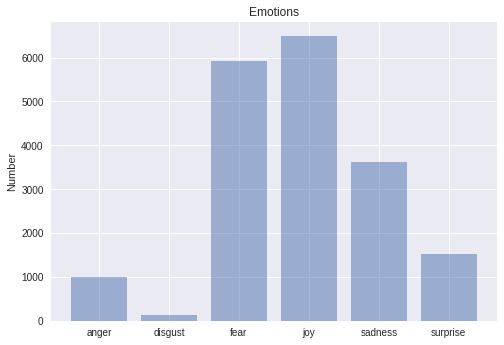

In [23]:
crowd_flower_dataset = CrowdFlowerDataset()
train_data_original, test_data = crowd_flower_dataset.load_data()

emotions = train_data_original.emotion.unique()
dic = crowd_flower_dataset.get_classes_dict()
labels = crowd_flower_dataset.get_classes()
print(dic)
print(labels)

for emotion in labels:
  train_data_original.loc[train_data_original.emotion == emotion, "emotion_int"] = dic[emotion]
  test_data.loc[test_data.emotion == emotion, "emotion_int"] = dic[emotion]
  
num_bins = crowd_flower_dataset.get_num_classes()
bins = [0,1,2,3,4,5,6]
hist, _ = np.histogram(train_data_original["emotion_int"], bins=bins)

objects = crowd_flower_dataset.get_classes()
y_pos = np.arange(len(objects))

plt.bar(y_pos, hist, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Number')
plt.title('Emotions')
 
plt.show()

The training data is very imbalanced!

In [24]:
train_data, val_data = train_test_split(train_data_original, test_size=0.1, random_state=RANDOM_STATE, stratify=train_data_original["emotion"].values)

print('y_train {}'.format(Counter(train_data["emotion"].values)))
print('y_val {}'.format(Counter(val_data["emotion"].values)))
print('y_test {}'.format(Counter(test_data["emotion"].values)))

y_train Counter({'joy': 5840, 'fear': 5329, 'sadness': 3254, 'surprise': 1378, 'anger': 903, 'disgust': 112})
y_val Counter({'joy': 649, 'fear': 592, 'sadness': 362, 'surprise': 153, 'anger': 100, 'disgust': 13})
y_test Counter({'joy': 2781, 'fear': 2538, 'sadness': 1549, 'surprise': 656, 'anger': 430, 'disgust': 54})


In [25]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', -1)
train_data[["text", "emotion", "emotion_int"]].head(10)

,text,emotion,emotion_int
24875,Woke up this morning to the line &quot;I made this half-pony half-monkey monster to please you But I get the feeling that you don't like it &quot;,sadness,4.0
21876,i guess i'll do both since i cant really decide which one to choose,joy,3.0
38377,"@jaulin Maybe you have, my memory sucks.",anger,0.0
36403,@Yorksville ...Yawn is it that time already!,surprise,5.0
16933,"@vicki_xx :O really well if u want, we can go 2gether next yr?",joy,3.0
24896,@DonoLooLoo i feel like tweeting you for no reason. so um hiiiiii.,joy,3.0
34365,Your the supporter its totally up to you,joy,3.0
28718,New Twitter coolness: conversations with neighbors (http://is.gd/ybd0) during a thunderstorm.,joy,3.0
2223,@JasonVonBerg thats the crazy part - was for 16:30. but reasons include &quot;full schedule&quot; &amp; &quot;travelling with his daughter&quot;... So. Not. Cool,sadness,4.0
22842,"@echsizzles I am in Kuala Lumpur. And I know I vanished, haha! I broke up with my last boyfriend, that's why I'm back!",fear,2.0


### Tokenize training and test dataset

In [0]:
NUM_WORDS=60000
texts = train_data["text"].values

In [0]:
from collections import OrderedDict
from collections import defaultdict
from nltk.tokenize import TweetTokenizer


class CustomTweetTokenizer(object):
  
    def __init__(self, num_words=None,
                 filters='!"$%&()*+,-./:;<=>?[\\]^_`{|}~\t\n',
                 lower=True,
                 char_level=False,
                 oov_token=None,
                 document_count=0,
                 **kwargs):
        # Legacy support
        if 'nb_words' in kwargs:
            warnings.warn('The `nb_words` argument in `Tokenizer` '
                          'has been renamed `num_words`.')
            num_words = kwargs.pop('nb_words')
        if kwargs:
            raise TypeError('Unrecognized keyword arguments: ' + str(kwargs))

        self.tokenizer = TweetTokenizer(reduce_len=True)
        self.word_counts = OrderedDict()
        self.filters = filters
        self.word_docs = defaultdict(int)
        self.lower = lower
        self.num_words = num_words
        self.document_count = document_count
        self.char_level = char_level
        self.oov_token = oov_token
        self.index_docs = defaultdict(int)
        self.word_index = dict()
        self.index_word = dict()
    
    def text_to_word_sequence(self, text, filters='!"$%&()*+,-./:;<=>?[\\]^_`{|}~\t\n', lower=True):
        if lower:
            text = text.lower()
        tokens = self.tokenizer.tokenize(text)
        # tokens = filter(lambda t: not t.startswith('@'), tokens)
        # tokens = filter(lambda t: not t.startswith('#'), tokens)
        tokens = filter(lambda t: not t.startswith('http'), tokens)
        tokens = filter(lambda t: not t in list(c for c in filters), tokens)
        return list(tokens)

    def fit_on_texts(self, texts):
        """Updates internal vocabulary based on a list of texts.
        In the case where texts contains lists,
        we assume each entry of the lists to be a token.
        Required before using `texts_to_sequences` or `texts_to_matrix`.
        # Arguments
            texts: can be a list of strings,
                a generator of strings (for memory-efficiency),
                or a list of list of strings.
        """
        for text in texts:
            self.document_count += 1
            if self.char_level or isinstance(text, list):
                if self.lower:
                    if isinstance(text, list):
                        text = [text_elem.lower() for text_elem in text]
                    else:
                        text = text.lower()
                seq = text
            else:
                seq = self.text_to_word_sequence(text, self.filters, self.lower)
            for w in seq:
                if w in self.word_counts:
                    self.word_counts[w] += 1
                else:
                    self.word_counts[w] = 1
            for w in set(seq):
                # In how many documents each word occurs
                self.word_docs[w] += 1

        wcounts = list(self.word_counts.items())
        wcounts.sort(key=lambda x: x[1], reverse=True)
        # forcing the oov_token to index 1 if it exists
        if self.oov_token is None:
            sorted_voc = []
        else:
            sorted_voc = [self.oov_token]
        sorted_voc.extend(wc[0] for wc in wcounts)

        # note that index 0 is reserved, never assigned to an existing word
        self.word_index = dict(
            list(zip(sorted_voc, list(range(1, len(sorted_voc) + 1)))))

        self.index_word = dict((c, w) for w, c in self.word_index.items())

        for w, c in list(self.word_docs.items()):
            self.index_docs[self.word_index[w]] = c

    def texts_to_sequences(self, texts):
        """Transforms each text in texts to a sequence of integers.
        Only top "num_words" most frequent words will be taken into account.
        Only words known by the tokenizer will be taken into account.
        # Arguments
            texts: A list of texts (strings).
        # Returns
            A list of sequences.
        """
        return list(self.texts_to_sequences_generator(texts))

    def texts_to_sequences_generator(self, texts):
        """Transforms each text in `texts` to a sequence of integers.
        Each item in texts can also be a list,
        in which case we assume each item of that list to be a token.
        Only top "num_words" most frequent words will be taken into account.
        Only words known by the tokenizer will be taken into account.
        # Arguments
            texts: A list of texts (strings).
        # Yields
            Yields individual sequences.
        """
        num_words = self.num_words
        oov_token_index = self.word_index.get(self.oov_token)
        for text in texts:
            if self.char_level or isinstance(text, list):
                if self.lower:
                    if isinstance(text, list):
                        text = [text_elem.lower() for text_elem in text]
                    else:
                        text = text.lower()
                seq = text
            else:
                seq = self.text_to_word_sequence(text, self.filters, self.lower)
            vect = []
            for w in seq:
                i = self.word_index.get(w)
                if i is not None:
                    if num_words and i >= num_words:
                        if oov_token_index is not None:
                            vect.append(oov_token_index)
                    else:
                        vect.append(i)
                elif self.oov_token is not None:
                    vect.append(oov_token_index)
            yield vect

In [28]:
NUM_WORDS=60000
texts = train_data["text"].values
tokenizer = CustomTweetTokenizer(num_words=NUM_WORDS,filters='!"$%&()*+,-./:;<=>?[\\]^_`{|}~\t\n',
                      lower=True)
tokenizer.fit_on_texts(texts)
sequences_train = tokenizer.texts_to_sequences(texts)
sequences_val = tokenizer.texts_to_sequences(val_data["text"].values)
sequences_test = tokenizer.texts_to_sequences(test_data["text"].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 26201 unique tokens.


In [0]:
reverse_word_index = []
for word in word_index:
  reverse_word_index.append(word)

In [30]:
words = []
for index in sequences_train[2]:
  words.append(reverse_word_index[index - 1])
print(words)

['@jaulin', 'maybe', 'you', 'have', 'my', 'memory', 'sucks']


In [31]:
X_train_unbalanced = pad_sequences(sequences_train)
X_val = pad_sequences(sequences_val, maxlen=X_train_unbalanced.shape[1])
X_test = pad_sequences(sequences_test, maxlen=X_train_unbalanced.shape[1])

y_train_unbalanced = np.asarray(train_data.emotion.apply(lambda x:dic[x]))
y_val = np.asarray(val_data.emotion.apply(lambda x:dic[x]))
y_test = np.asarray(test_data.emotion.apply(lambda x:dic[x]))

print('Shape of X train, val and test tensor:', X_train_unbalanced.shape, X_val.shape, X_test.shape)
print('Shape of label train, val and test tensor:', y_train_unbalanced.shape, y_val.shape, y_test.shape)

Shape of X train, val and test tensor: (16816, 34) (1869, 34) (8008, 34)
Shape of label train, val and test tensor: (16816,) (1869,) (8008,)


### Balance Training dataset using SMOTE

In [32]:
sm = SMOTE(random_state=RANDOM_STATE)
X_train_smote, y_train_smote = sm.fit_sample(X_train_unbalanced, y_train_unbalanced)

print('Shape of X train tensor which is balanced using SMOTE:', X_train_smote.shape)
print('Original label shape {}'.format(Counter(y_train_unbalanced)))
print('Resampled label shape {}'.format(Counter(y_train_smote)))

Shape of X train tensor which is balanced using SMOTE: (35040, 34)
Original label shape Counter({3: 5840, 2: 5329, 4: 3254, 5: 1378, 0: 903, 1: 112})
Resampled label shape Counter({4: 5840, 3: 5840, 0: 5840, 5: 5840, 2: 5840, 1: 5840})


### Balance Training dataset using Random Over Sampler

In [33]:
ros = RandomOverSampler(random_state=RANDOM_STATE)
X_train_ros, y_train_ros = ros.fit_sample(X_train_unbalanced, y_train_unbalanced)

print('Shape of X train tensor which is balanced using ROS:', X_train_ros.shape)
print('Original label shape {}'.format(Counter(y_train_unbalanced)))
print('Resampled label shape {}'.format(Counter(y_train_ros)))

Shape of X train tensor which is balanced using ROS: (35040, 34)
Original label shape Counter({3: 5840, 2: 5329, 4: 3254, 5: 1378, 0: 903, 1: 112})
Resampled label shape Counter({4: 5840, 3: 5840, 0: 5840, 5: 5840, 2: 5840, 1: 5840})


In [0]:
X_train = X_train_ros
y_train = y_train_ros

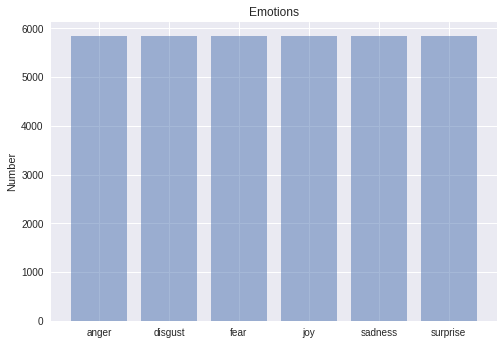

In [35]:
hist, _ = np.histogram(y_train, bins=bins)

y_pos = np.arange(len(objects))

plt.bar(y_pos, hist, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Number')
plt.title('Emotions')
 
plt.show()

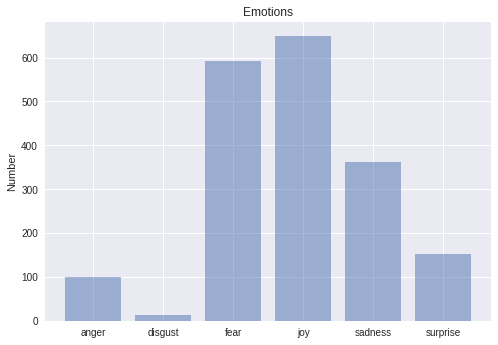

In [36]:
hist, _ = np.histogram(y_val, bins=bins)

y_pos = np.arange(len(objects))

plt.bar(y_pos, hist, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Number')
plt.title('Emotions')
 
plt.show()

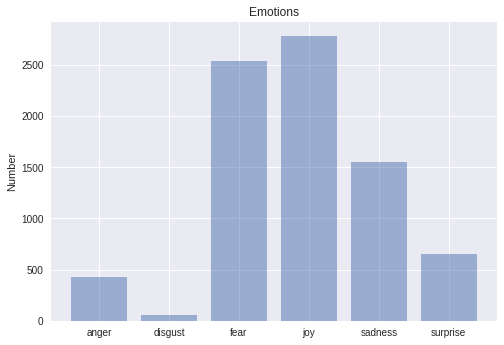

In [37]:
hist, _ = np.histogram(y_test, bins=bins)

y_pos = np.arange(len(objects))

plt.bar(y_pos, hist, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Number')
plt.title('Emotions')
 
plt.show()

In [38]:
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

print('Shape of X train, validation and test tensor:', X_train.shape, X_val.shape, X_test.shape)
print('Shape of label train, validation and test tensor:', y_train.shape, y_val.shape, y_test.shape)

Shape of X train, validation and test tensor: (35040, 34) (1869, 34) (8008, 34)
Shape of label train, validation and test tensor: (35040, 6) (1869, 6) (8008, 6)


In [0]:
import gensim
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

from gensim.models.keyedvectors import KeyedVectors

# word_vectors = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)
word_vectors = KeyedVectors.load_word2vec_format('word2vec_twitter_model.bin', binary=True, unicode_errors='ignore')

In [40]:
EMBEDDING_DIM=400
vocabulary_size = min(len(word_index)+1, NUM_WORDS)
embedding_matrix = np.zeros((vocabulary_size, EMBEDDING_DIM))

print("vocabulary_size:", vocabulary_size)
print("embedding_matrix shape:", embedding_matrix.shape)

vocabulary_size: 26202
embedding_matrix shape: (26202, 400)


In [0]:
for word, i in word_index.items():
    if i>=NUM_WORDS:
        continue
    try:
        embedding_vector = word_vectors[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        embedding_matrix[i] = np.random.normal(0,np.sqrt(0.25), EMBEDDING_DIM)

del(word_vectors)

from keras.layers import Embedding
embedding_layer = Embedding(vocabulary_size,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            trainable=True)

In [42]:
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model
from keras.layers import Input, Dense, Embedding, Conv2D, MaxPooling2D, Dropout, concatenate, LSTM
from keras.layers.core import Reshape, Flatten
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam, Adadelta, RMSprop
from keras.models import Model
from keras import regularizers
sequence_length = X_train.shape[1]
filter_sizes = [3,4,5]
num_filters = 100
drop_rate = 0.5
n_class = num_bins

print(sequence_length)

inputs = Input(shape=(sequence_length,), name='input_1')
embedding = embedding_layer(inputs)
reshape = Reshape((sequence_length, EMBEDDING_DIM, 1), name='reshape_1')(embedding)

conv_1 = Conv2D(num_filters, (filter_sizes[0], EMBEDDING_DIM), activation='relu',kernel_regularizer=regularizers.l2(0.01), name='conv_1')(reshape)
conv_2 = Conv2D(num_filters, (filter_sizes[1], EMBEDDING_DIM), activation='relu',kernel_regularizer=regularizers.l2(0.01), name='conv_2')(reshape)
conv_3 = Conv2D(num_filters, (filter_sizes[2], EMBEDDING_DIM), activation='relu',kernel_regularizer=regularizers.l2(0.01), name='conv_3')(reshape)

maxpool_1 = MaxPooling2D((sequence_length - filter_sizes[0] + 1, 1), strides=1, name='maxpool_1')(conv_1)
maxpool_2 = MaxPooling2D((sequence_length - filter_sizes[1] + 1, 1), strides=1, name='maxpool_2')(conv_2)
maxpool_3 = MaxPooling2D((sequence_length - filter_sizes[2] + 1, 1), strides=1, name='maxpool_3')(conv_3)

merged_tensor = concatenate([maxpool_1, maxpool_2, maxpool_3], axis=1, name='concatenate_1')
flatten = Flatten()(merged_tensor)
dropout = Dropout(drop_rate, name='dropout_1')(flatten)
output = Dense(units=n_class, activation='softmax',kernel_regularizer=regularizers.l2(0.01), name='dense_1')(dropout)

# this creates a model that includes
model = Model(inputs, output)

model.summary()

34
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 34)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 34, 400)      10480800    input_1[0][0]                    
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 34, 400, 1)   0           embedding_1[0][0]                
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 32, 1, 100)   120100      reshape_1[0][0]                  
__________________________________________________________________________________________________
conv_2 

In [43]:
adam = Adam(lr=1e-3, decay=0.0)
adadelta = Adadelta(lr=1.0, rho=0.95, epsilon=None, decay=0.0)
rmsprop = RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)

model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['acc'])
callbacks = [EarlyStopping(monitor='val_loss', patience=5)]
history = model.fit(X_train, y_train, batch_size=1000, epochs=100, verbose=1, validation_data=(X_val, y_val), callbacks=callbacks)  # starts training

Train on 35040 samples, validate on 1869 samples
Epoch 1/100
35040/35040 [==============================] - 11s 309us/step - loss: 1.6751 - acc: 0.4670 - val_loss: 1.7535 - val_acc: 0.4312
Epoch 2/100
35040/35040 [==============================] - 6s 167us/step - loss: 1.4102 - acc: 0.6192 - val_loss: 1.7092 - val_acc: 0.4296
Epoch 3/100
35040/35040 [==============================] - 6s 167us/step - loss: 1.2808 - acc: 0.6782 - val_loss: 1.7198 - val_acc: 0.4007
Epoch 4/100
35040/35040 [==============================] - 6s 167us/step - loss: 1.1783 - acc: 0.7223 - val_loss: 1.6515 - val_acc: 0.4741
Epoch 5/100
35040/35040 [==============================] - 6s 167us/step - loss: 1.0841 - acc: 0.7620 - val_loss: 1.6821 - val_acc: 0.4639
Epoch 6/100
35040/35040 [==============================] - 6s 168us/step - loss: 0.9984 - acc: 0.7975 - val_loss: 1.6739 - val_acc: 0.4580
Epoch 7/100
35040/35040 [==============================] - 6s 168us/step - loss: 0.9317 - acc: 0.8282 - val_loss: 1.

In [0]:
sequences_test=tokenizer.texts_to_sequences(test_data.text)
X_test = pad_sequences(sequences_test, maxlen=X_test.shape[1])
y_pred = model.predict(X_test)

In [45]:
history.history.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

In [0]:
y_pred_original = [labels[val] for val in np.argmax(y_pred, axis=1).squeeze()]
y_test_original = np.asarray(test_data.emotion)

In [0]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (4,3), fontsize=15):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

In [48]:
cf_matrix = confusion_matrix(y_test_original, y_pred_original, labels=labels)

df_cm = pd.DataFrame(
    cf_matrix, index=labels, columns=labels, 
)

df_cm

,anger,disgust,fear,joy,sadness,surprise
anger,128,5,143,45,94,15
disgust,11,8,17,8,7,3
fear,131,16,1041,518,635,197
joy,52,12,518,1781,223,195
sadness,94,22,483,249,620,81
surprise,32,2,173,248,101,100


Figure(288x216)


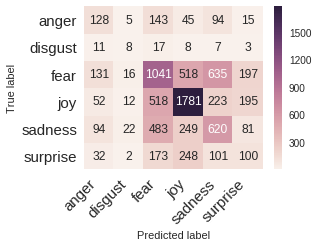

In [49]:
print(print_confusion_matrix(cf_matrix, class_names=labels))

In [50]:
test_accuracy = accuracy_score(y_test_original, y_pred_original)
print("test accuracy:", test_accuracy)

test accuracy: 0.4592907092907093


### Performance score for each classes

In [51]:
precision, recall, fscore, support = precision_recall_fscore_support(y_test_original, y_pred_original)
score_dict = {
  "precision": precision.round(4),
  "recall": recall.round(4),
  "f1-score": fscore.round(4),
  "support": support.round(4)
}
score_df = pd.DataFrame(score_dict, index=labels)
score_df

,f1-score,precision,recall,support
anger,0.2916,0.2857,0.2977,430
disgust,0.1345,0.1231,0.1481,54
fear,0.4238,0.4383,0.4102,2538
joy,0.6327,0.6251,0.6404,2781
sadness,0.3840,0.3690,0.4003,1549
surprise,0.1604,0.1692,0.1524,656


### Performance score using micro average

In [52]:
precision, recall, fscore, support = precision_recall_fscore_support(y_test_original, y_pred_original, average="micro")
score_dict = {
  "precision": precision.round(4),
  "recall": recall.round(4),
  "f1-score": fscore.round(4),
  "support": support
}
score_df = pd.DataFrame(score_dict, index=["score"])
score_df

,f1-score,precision,recall,support
score,0.4593,0.4593,0.4593,None


### Performance score using macro average

In [53]:
precision, recall, fscore, support = precision_recall_fscore_support(y_test_original, y_pred_original, average="macro")
score_dict = {
  "precision": precision.round(4),
  "recall": recall.round(4),
  "f1-score": fscore.round(4),
  "support": support
}
score_df = pd.DataFrame(score_dict, index=["score"])
score_df

,f1-score,precision,recall,support
score,0.3378,0.3351,0.3415,None


### Performance score using weighted average

In [54]:
precision, recall, fscore, support = precision_recall_fscore_support(y_test_original, y_pred_original, average="weighted")
score_dict = {
  "precision": precision.round(4),
  "recall": recall.round(4),
  "f1-score": fscore.round(4),
  "support": support
}
score_df = pd.DataFrame(score_dict, index=["score"])
score_df

,f1-score,precision,recall,support
score,0.458,0.4574,0.4593,None
